## Displacement

In [45]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.extraction import AE
from dataset.FeatureExtraction import FeatureExtractionDataset
from torch.utils.data import DataLoader

In [46]:
def denormalize(signal):
    min_max = pd.read_csv("./Data/Displacement/min_max.csv").values
    n = signal.shape[0]
    output_signal = torch.zeros_like(signal, dtype=torch.float32)
    for i in range(n):
        for j in range(5):
            output_signal[i, j, :] = signal[i, j, :] * (min_max[j][1] - min_max[j][0]) + min_max[j][0]

    return output_signal

In [47]:
ae = AE.load_from_checkpoint("./Logs/Extraction/Displacement/LAST/version_0/checkpoints/epoch=00197-val_loss=0.00000553.ckpt").eval().to("cuda")

In [48]:
mode = "test"
source = "Displacement"
dataset = FeatureExtractionDataset(path="./Data", source=source, mode=mode)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [49]:
signal = []
AE_prediction = []

with torch.no_grad():
    for input in dataloader: 
        input = input.to("cuda")
        signal  += input.unsqueeze(0)
        AE_prediction  += ae(input)[0].unsqueeze(0)

signal = torch.concat(signal).cpu()
AE_prediction = torch.concat(AE_prediction).cpu()

In [50]:
signal = denormalize(signal)
AE_prediction = denormalize(AE_prediction)

In [51]:
import torch.nn as nn
mean_squared_error = nn.MSELoss()
mse_ae = mean_squared_error(signal, AE_prediction)
print(f"MSE of AE: {mse_ae:.3E}")


rmse_ae = torch.sqrt(mse_ae)

print(f"RMSE of AE: {rmse_ae:.3E}")


nrmse_ae = rmse_ae / (signal.max() - signal.min())
print(f"NRMSE of AE: {nrmse_ae*100:.2f} %")

MSE of AE: 2.349E-06
RMSE of AE: 1.532E-03
NRMSE of AE: 0.20 %


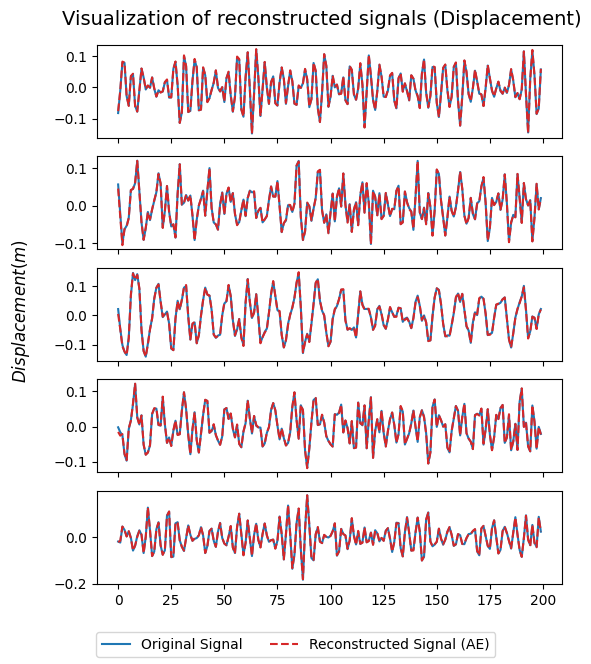

In [52]:
fig, axes = plt.subplots(5, 1, figsize=(6,7), sharex=True)
length = 200
for i in range(5):
    line1 = axes[i].plot(range(len(signal[0, i, :length])), signal[0, i, :length], color="tab:blue",  label="Original Signal")
    line2 = axes[i].plot(range(len(AE_prediction[0, i, :length])), AE_prediction[0, i, :length], color="tab:red", linestyle='dashed', label="Reconstructed Signal (AE)")
fig.legend(handles =[line1[0], line2[0]], loc ='lower center', ncol=2)
fig.suptitle('Visualization of reconstructed signals (Displacement)', fontsize=14, y=0.93)
fig.supylabel(r'$Displacement(m)$', x=-0.02)

plt.savefig(f"./pic/reconstructed-disp({mode}).svg", bbox_inches='tight')
plt.savefig(f"./pic/reconstructed-disp({mode}).png", bbox_inches='tight', dpi=500)

## Acceleration

In [53]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.extraction import AE
from dataset.FeatureExtraction import FeatureExtractionDataset
from torch.utils.data import DataLoader

In [54]:
def denormalize(signal):
    min_max = pd.read_csv("./Data/Acceleration/min_max.csv").values
    n = signal.shape[0]
    output_signal = torch.zeros_like(signal, dtype=torch.float32)
    for i in range(n):
        for j in range(5):
            output_signal[i, j, :] = signal[i, j, :] * (min_max[j][1] - min_max[j][0]) + min_max[j][0]

    return output_signal

In [55]:
ae = AE.load_from_checkpoint("./Logs/Extraction/Acceleration/LAST/version_0/checkpoints/epoch=00200-val_loss=0.00034191.ckpt").eval().to("cuda")

In [56]:
mode = "test"
source = "Acceleration"
dataset = FeatureExtractionDataset(path="./Data", source=source, mode=mode)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [57]:
signal = []
AE_prediction = []


with torch.no_grad():
    for input in dataloader: 
        input = input.to("cuda")
        signal  += input.unsqueeze(0)
        AE_prediction  += ae(input)[0].unsqueeze(0)


signal = torch.concat(signal).cpu()
AE_prediction = torch.concat(AE_prediction).cpu()


In [58]:
signal = denormalize(signal)
AE_prediction = denormalize(AE_prediction)

In [59]:
import torch.nn as nn
mean_squared_error = nn.MSELoss()
mse_ae = mean_squared_error(signal, AE_prediction)
print(f"MSE of AE: {mse_ae:.3E}")

rmse_ae = torch.sqrt(mse_ae)
print(f"RMSE of AE: {rmse_ae:.3E}")

nrmse_ae= rmse_ae / (signal.max() - signal.min())
print(f"NRMSE of AE: {nrmse_ae*100:.2f} %")

MSE of AE: 6.659E-06
RMSE of AE: 2.581E-03
NRMSE of AE: 1.32 %


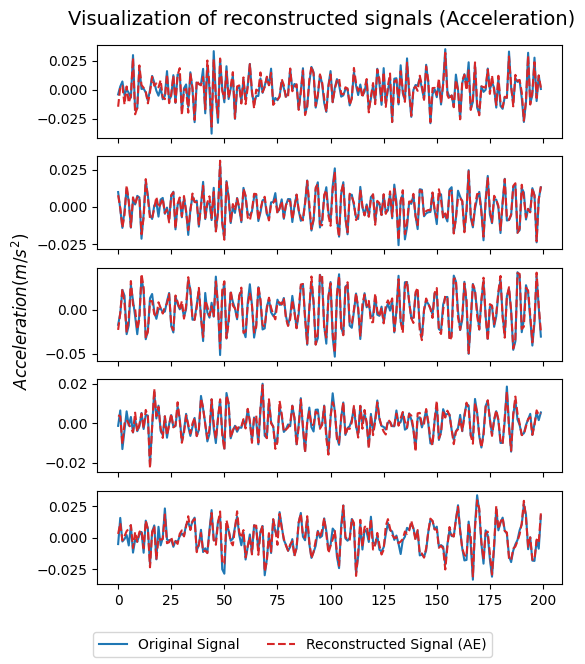

In [60]:
fig, axes = plt.subplots(5, 1, figsize=(6,7), sharex=True)
length = 200
for i in range(5):
    line1 = axes[i].plot(range(len(signal[0, i, :length])), signal[0, i, :length], color="tab:blue", label="Original Signal")
    line2 = axes[i].plot(range(len(AE_prediction[0, i, :length])), AE_prediction[0, i, :length], color="tab:red", linestyle='dashed', label="Reconstructed Signal (AE)")
fig.legend(handles =[line1[0], line2[0]], loc ='lower center', ncol=4)
fig.suptitle('Visualization of reconstructed signals (Acceleration)', fontsize=14, y=0.93)
fig.supylabel(r'$Acceleration(m/s^2)$', x=-0.02)

plt.savefig(f"./pic/reconstructed-accel({mode}).svg", bbox_inches='tight')
plt.savefig(f"./pic/reconstructed-accel({mode}).png", bbox_inches='tight', dpi=500)